In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
from shapely.geometry import Point
import seaborn as sns

# Loading and cleaning

In [2]:
london_boroughs = [
    "Barking and Dagenham", "Barnet", "Bexley", "Brent", "Bromley",
    "Camden", "Croydon", "Ealing", "Enfield", "Greenwich", "Hackney",
    "Hammersmith and Fulham", "Haringey", "Harrow", "Havering",
    "Hillingdon", "Hounslow", "Islington", "Kensington and Chelsea",
    "Kingston upon Thames", "Lambeth", "Lewisham", "Merton", "Newham",
    "Redbridge", "Richmond upon Thames", "Southwark", "Sutton",
    "Tower Hamlets", "Waltham Forest", "Wandsworth", "Westminster"
]


In [3]:
shape_path = r'C:\Users\Usuario\Desktop\TUE\Data Challenge 2\data\Shapefiles\statistical-gis-boundaries-london\ESRI\LSOA_2011_London_gen_MHW.shp'
shape = gpd.read_file(shape_path)

In [4]:
sas_clean_path = r"C:\Users\Usuario\Desktop\TUE\Data Challenge 2\data\stop_and_search_data_with_borough.csv"
pas_clean_path = r"C:\Users\Usuario\Desktop\TUE\Data Challenge 2\data\PAS_stop_and_search.csv"
df_sas_clean = pd.read_csv(sas_clean_path)
df_pas_clean = pd.read_csv(pas_clean_path)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_17632\4074180973.py:4: DtypeWarning: Columns (7,8,11,12,13,14,15,16,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df_pas_clean = pd.read_csv(pas_clean_path)


In [5]:
df_census = pd.read_csv(r"C:\Users\Usuario\Desktop\TUE\Data Challenge 2\data\Ethnic group - 2021.csv")
df_trust_confidence = pd.read_csv(r"C:\Users\Usuario\Desktop\TUE\Data Challenge 2\data\PAS_Dashboard_Borough.csv")

In [6]:
df_pas_clean = df_pas_clean.rename(columns={"Unnamed: 0":"ID"})

In [7]:
df_census_borough = df_census.groupby("local authority name").sum()

In [8]:
ethnicity_mapping = {
    'White Other': 'White',
    'White British': 'White',
    'White Gypsy/Irish Traveller': 'White',
    'White Irish': 'White',
    'Black African': 'Black',
    'Black Caribbean': 'Black',
    'Black Other': 'Black',
    'Asian Bangladeshi': 'Asian',
    'Asian Indian': 'Asian',
    'Asian Pakistani': 'Asian',
    'Asian Chinese': 'Asian',
    'Asian Other': 'Asian',
    'Mixed White and Asian': 'Mixed',
    'Mixed White and Black African': 'Mixed',
    'Mixed White and Black Caribbean': 'Mixed',
    'Mixed Other': 'Mixed',
    'Other Arab': 'Other',
    'Other Any other': 'Other'
}

df_census_agg = df_census_borough.groupby(df_census_borough.columns.map(ethnicity_mapping), axis=1).sum()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_17632\53884172.py:22: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_census_agg = df_census_borough.groupby(df_census_borough.columns.map(ethnicity_mapping), axis=1).sum()


In [9]:
df_census_agg['Black'] = df_census_agg['Black'] + df_census_agg['Mixed']
df_census_agg = df_census_agg.drop(columns = ["Mixed"])

In [10]:
df_sas_clean.head()

Unnamed: 0.1  Unnamed: 0                       Type  \
0        178930      178930              Person search   
1        178931      178931  Person and Vehicle search   
2        178932      178932              Person search   
3        178933      178933              Person search   
4        178934      178934              Person search   

                        Date   Latitude  Longitude  Gender Age range  \
0  2016-05-31 23:01:00+00:00  51.455989  -0.043536    Male     10-17   
1  2016-05-31 23:05:00+00:00  51.475561  -0.075330    Male       NaN   
2  2016-05-31 23:07:00+00:00  51.533030  -0.203277    Male     18-24   
3  2016-05-31 23:10:00+00:00  51.553184  -0.176043    Male     18-24   
4  2016-05-31 23:10:00+00:00  51.553184  -0.176043  Female     18-24   

                           Self-defined ethnicity Officer-defined ethnicity  \
0           Black or Black British - African (B2)                     Black   
1                                 Not Stated (NS)                     Black   
2         Black or Black British - Caribbean (B1)                     Black   
3                                 Not Stated (NS)                     White   
4  White - Any other White ethnic background (W9)                     White   

                                         Legislation  \
0              Misuse of Drugs Act 1971 (section 23)   
1              Misuse of Drugs Act 1971 (section 23)   
2  Police and Criminal Evidence Act 1984 (section 1)   
3  Police and Criminal Evidence Act 1984 (section 1)   
4  Police and Criminal Evidence Act 1984 (section 1)   

                      Object of search                            Outcome  \
0                     Controlled drugs  Nothing found - no further action   
1                     Controlled drugs  Nothing found - no further action   
2  Articles for use in criminal damage  Nothing found - no further action   
3  Articles for use in criminal damage  Nothing found - no further action   
4  Articles for use in criminal damage  Nothing found - no further action   

     Borough  year  month  day  hour  
0   Lewisham  2016      5   31    23  
1  Southwark  2016      5   31    23  
2      Brent  2016      5   31    23  
3     Camden  2016      5   31    23  
4     Camden  2016      5   31    23

In [11]:
df_pas_clean = df_pas_clean[df_pas_clean['Ethnicity'] != 'Refused']

# Combine 'Mixed' and 'Other'
df_pas_clean.loc[df_pas_clean['Ethnicity'].isin(['Mixed','Other']), 'Ethnicity'] = 'Other'

# Combine 'White British' and 'White Other'
df_pas_clean.loc[df_pas_clean['Ethnicity'].isin(['White British', 'White Other']), 'Ethnicity'] = 'White'


In [12]:
# Check the unique values and their frequency in the 'Self-defined ethnicity' column
ethnicity_counts_pas = df_pas_clean['Ethnicity'].value_counts()

# Display the result in a DataFrame format
ethnicity_counts_pas_df = ethnicity_counts_pas.reset_index()
ethnicity_counts_pas_df.columns = ['Ethnicity', 'Frequency']

ethnicity_counts_pas_df

Ethnicity  Frequency
0     White      48803
1     Asian      12248
2     Black       9248
3     Other       4760

# Mapping self defined race into Asian, White, Black or other

In [27]:
# Check the unique values and their frequency in the 'Self-defined ethnicity' column
ethnicity_counts = df_sas_clean['Self-defined ethnicity'].value_counts()

# Display the result in a DataFrame format
ethnicity_counts_df = ethnicity_counts.reset_index()
ethnicity_counts_df.columns = ['Self-defined ethnicity', 'Frequency']

ethnicity_counts_df

Self-defined ethnicity  Frequency
0                     Other ethnic group - Not stated     279320
1   White - English/Welsh/Scottish/Northern Irish/...     233258
2   Black/African/Caribbean/Black British - Any ot...     152477
3                  White - Any other White background     139197
4     Black/African/Caribbean/Black British - African     101207
5    Asian/Asian British - Any other Asian background      79749
6   Black/African/Caribbean/Black British - Caribbean      66790
7                   Asian/Asian British - Bangladeshi      41571
8         Other ethnic group - Any other ethnic group      34080
9   Mixed/Multiple ethnic groups - Any other Mixed...      23586
10                         White - White British (W1)      23180
11                    Asian/Asian British - Pakistani      19902
12                       Asian/Asian British - Indian      18750
13     White - Any other White ethnic background (W9)      12842
14  Mixed/Multiple ethnic groups - White and Black...      12699
15  Black or Black British - Any other Black ethni...      12526
16              Black or Black British - African (B2)      10861
17                                    Not Stated (NS)      10706
18                                      White - Irish      10559
19            Black or Black British - Caribbean (B1)       9229
20  Asian or Asian British - Any other Asian ethni...       5900
21  Mixed/Multiple ethnic groups - White and Black...       4464
22          Asian or Asian British - Bangladeshi (A3)       3528
23     Mixed/Multiple ethnic groups - White and Asian       2908
24  Chinese or other ethnic group - Any other ethn...       2391
25               Asian or Asian British - Indian (A1)       1938
26     Mixed - Any other Mixed ethnic background (M9)       1858
27            Asian or Asian British - Pakistani (A2)       1855
28                      Asian/Asian British - Chinese       1778
29             Mixed - White and Black Caribbean (M1)       1595
30                           White - White Irish (W2)       1210
31               Mixed - White and Black African (M2)        465
32                       Mixed - White and Asian (M3)        270
33       Chinese or other ethnic group - Chinese (O1)        207

In [28]:
officer_ethnicity_counts = df_sas_clean['Officer-defined ethnicity'].value_counts()

# Display the result in a DataFrame format
officer_ethnicity_counts_df = officer_ethnicity_counts.reset_index()
officer_ethnicity_counts_df.columns = ['Officer-defined ethnicity', 'Frequency']

officer_ethnicity_counts_df

Officer-defined ethnicity  Frequency
0                     Black     517163
1                     White     515581
2                     Asian     219585
3                     Other      60077

In [29]:
white_ethnicities = [
    'White - English/Welsh/Scottish/Northern Irish/British',
    'White - Any other White background',
    'White - White British (W1)',
    'White - Any other White ethnic background (W9)',
    'White - Irish',
    'White - White Irish (W2)'
]
black_ethnicities = [
    'Black/African/Caribbean/Black British - Any other Black/African/Caribbean background',
    'Black/African/Caribbean/Black British - African',
    'Black/African/Caribbean/Black British - Caribbean',
    'Black or Black British - Any other Black ethnic background (B9)',
    'Black or Black British - African (B2)',
    'Black or Black British - Caribbean (B1)'
]
asian_ethnicities = [
    'Asian/Asian British - Any other Asian background',
    'Asian/Asian British - Bangladeshi',
    'Asian/Asian British - Pakistani',
    'Asian/Asian British - Indian',
    'Asian or Asian British - Any other Asian ethnic background (A9)',
    'Asian or Asian British - Bangladeshi (A3)',
    'Asian or Asian British - Indian (A1)',
    'Asian or Asian British - Pakistani (A2)',
    'Asian/Asian British - Chinese',
    'Chinese or other ethnic group - Chinese (O1)'
]
other_ethnicities = [
    'Mixed/Multiple ethnic groups - Any other Mixed/Multiple ethnic background',
    'Mixed/Multiple ethnic groups - White and Black Caribbean',
    'Mixed/Multiple ethnic groups - White and Black African',
    'Mixed/Multiple ethnic groups - White and Asian',
    'Other ethnic group - Any other ethnic group',
    'Mixed - Any other Mixed ethnic background (M9)',
    'Mixed - White and Black Caribbean (M1)',
    'Mixed - White and Black African (M2)',
    'Mixed - White and Asian (M3)',
    'Chinese or other ethnic group - Any other ethnic group (O9)',
    'Other ethnic group - Arab'
]


In [30]:
def map_ethnicity(ethnicity):
    if ethnicity in white_ethnicities:
        return 'White'
    elif ethnicity in black_ethnicities:
        return 'Black'
    elif ethnicity in asian_ethnicities:
        return 'Asian'
    elif ethnicity in other_ethnicities:
        return 'Other'
    else:
        pass

# Apply the mapping function to the dataframe
df_sas_clean['Self-defined ethnicity'] = df_sas_clean['Self-defined ethnicity'].apply(map_ethnicity)

# Display the updated dataframe


In [31]:
shape

LSOA11CD                   LSOA11NM   MSOA11CD  \
0     E01000001        City of London 001A  E02000001   
1     E01000002        City of London 001B  E02000001   
2     E01000003        City of London 001C  E02000001   
3     E01000005        City of London 001E  E02000001   
4     E01000006  Barking and Dagenham 016A  E02000017   
...         ...                        ...        ...   
4830  E01033742             Greenwich 007F  E02000319   
4831  E01033743             Greenwich 002H  E02000314   
4832  E01033744             Greenwich 007G  E02000319   
4833  E01033745             Greenwich 002I  E02000314   
4834  E01033746             Greenwich 038E  E02006931   

                      MSOA11NM    LAD11CD               LAD11NM    RGN11CD  \
0           City of London 001  E09000001        City of London  E12000007   
1           City of London 001  E09000001        City of London  E12000007   
2           City of London 001  E09000001        City of London  E12000007   
3           City of London 001  E09000001        City of London  E12000007   
4     Barking and Dagenham 016  E09000002  Barking and Dagenham  E12000007   
...                        ...        ...                   ...        ...   
4830             Greenwich 007  E09000011             Greenwich  E12000007   
4831             Greenwich 002  E09000011             Greenwich  E12000007   
4832             Greenwich 007  E09000011             Greenwich  E12000007   
4833             Greenwich 002  E09000011             Greenwich  E12000007   
4834             Greenwich 038  E09000011             Greenwich  E12000007   

     RGN11NM  USUALRES  HHOLDRES  COMESTRES  POPDEN  HHOLDS  AVHHOLDSZ  \
0     London      1465      1465          0   112.9     876        1.7   
1     London      1436      1436          0    62.9     830        1.7   
2     London      1346      1250         96   227.7     817        1.5   
3     London       985       985          0    52.0     467        2.1   
4     London      1703      1699          4   116.2     543        3.1   
...      ...       ...       ...        ...     ...     ...        ...   
4830  London      1352      1352          0   107.6     581        2.3   
4831  London      2038      2038          0    20.4     663        3.1   
4832  London      1845      1728        117   125.8     646        2.7   
4833  London      1820      1820          0    32.3     591        3.1   
4834  London      1464      1436         28   115.3     715        2.0   

                                               geometry  
0     POLYGON ((532105.092 182011.230, 532162.491 18...  
1     POLYGON ((532746.813 181786.891, 532671.688 18...  
2     POLYGON ((532135.145 182198.119, 532158.250 18...  
3     POLYGON ((533807.946 180767.770, 533649.063 18...  
4     POLYGON ((545122.049 184314.931, 545271.917 18...  
...                                                 ...  
4830  POLYGON ((544642.680 179824.674, 544766.313 17...  
4831  POLYGON ((546579.195 181097.813, 546687.036 18...  
4832  POLYGON ((544536.486 179447.115, 544602.630 17...  
4833  POLYGON ((546415.745 180152.270, 546320.715 18...  
4834  POLYGON ((538140.000 177313.000, 538129.177 17...  

[4835 rows x 15 columns]

In [32]:
df_cop_person_borough = df_sas_clean.groupby(['Borough', 'Self-defined ethnicity', 'Officer-defined ethnicity']).size().unstack(fill_value=0).stack().reset_index(name='count')
df_cop_person_borough

Borough Self-defined ethnicity Officer-defined ethnicity  \
0    Barking and Dagenham                  Asian                     Asian   
1    Barking and Dagenham                  Asian                     Black   
2    Barking and Dagenham                  Asian                     Other   
3    Barking and Dagenham                  Asian                     White   
4    Barking and Dagenham                  Black                     Asian   
..                    ...                    ...                       ...   
507           Westminster                  Other                     White   
508           Westminster                  White                     Asian   
509           Westminster                  White                     Black   
510           Westminster                  White                     Other   
511           Westminster                  White                     White   

     count  
0     5270  
1       40  
2       64  
3       65  
4       58  
..     ...  
507   2596  
508    256  
509    434  
510   1206  
511  26512  

[512 rows x 4 columns]

In [33]:
df_self_identified_percent = df_sas_clean.groupby(['Borough', 'Self-defined ethnicity']).size().unstack(fill_value=0)
df_self_identified_percent = df_self_identified_percent.div(df_self_identified_percent.sum(axis=1), axis=0).mul(100).reset_index()
average_self_identified = df_self_identified_percent.mean(numeric_only=True)
average_self_identified['Borough'] = 'Average'
df_self_identified_percent = pd.concat([df_self_identified_percent, pd.DataFrame([average_self_identified])], ignore_index=True)

# Calculate percentages for officer-identified ethnicities
df_officer_identified_percent = df_sas_clean.groupby(['Borough', 'Officer-defined ethnicity']).size().unstack(fill_value=0)
df_officer_identified_percent = df_officer_identified_percent.div(df_officer_identified_percent.sum(axis=1), axis=0).mul(100).reset_index()
average_officer_identified = df_officer_identified_percent.mean(numeric_only=True)
average_officer_identified['Borough'] = 'Average'
df_officer_identified_percent = pd.concat([df_officer_identified_percent, pd.DataFrame([average_officer_identified])], ignore_index=True)

df_officer_identified_percent

Officer-defined ethnicity                 Borough      Asian      Black  \
0                            Barking and Dagenham  21.105544  29.620703   
1                                          Barnet  13.517719  33.505672   
2                                          Bexley   4.684538  19.712970   
3                                           Brent  16.538263  49.894762   
4                                         Bromley   4.062517  28.344229   
5                                          Camden  12.799525  38.469106   
6                                         Croydon  10.695577  46.190807   
7                                          Ealing  28.719540  38.862841   
8                                         Enfield   7.172090  37.930225   
9                                       Greenwich   8.927591  40.296049   
10                                        Hackney  13.767895  53.133729   
11                         Hammersmith and Fulham   8.063600  45.435414   
12                                       Haringey   5.743209  49.668273   
13                                         Harrow  24.086395  34.235353   
14                                       Havering   8.847668  22.732602   
15                                     Hillingdon  24.684478  30.109341   
16                                       Hounslow  25.979221  26.612369   
17                                      Islington  10.263888  42.078593   
18                         Kensington and Chelsea   8.828073  39.341435   
19                           Kingston upon Thames  14.325267  20.604685   
20                                        Lambeth   4.589456  65.968749   
21                                       Lewisham   5.465567  57.349464   
22                                         Merton  18.413793  31.775862   
23                                         Newham  31.159036  34.811910   
24                                      Redbridge  39.838851  24.477000   
25                           Richmond upon Thames  12.081112  19.116527   
26                                      Southwark   6.154338  56.866857   
27                                         Sutton   9.106217  20.387957   
28                                  Tower Hamlets  58.250376  17.761332   
29                                 Waltham Forest  26.355294  36.284153   
30                                     Wandsworth  11.140795  49.111790   
31                                    Westminster  10.738371  33.368310   
32                                        Average  15.815806  36.689346   

Officer-defined ethnicity      Other      White  
0                           1.046556  48.227198  
1                           9.326373  43.650236  
2                           1.088546  74.513945  
3                           8.099361  25.467614  
4                           1.222326  66.370928  
5                           4.445311  44.286059  
6                           6.589766  36.523851  
7                           6.031390  26.386229  
8                           3.237169  51.660517  
9                           1.761360  49.015000  
10                          2.592528  30.505848  
11                          9.349634  37.151351  
12                          3.038980  41.549537  
13                          7.075472  34.602781  
14                          0.896072  67.523658  
15                          3.322389  41.883792  
16                          4.328431  43.079978  
17                          3.685821  43.971699  
18                         12.579167  39.251326  
19                          5.111025  59.959023  
20                          2.215243  27.226552  
21                          1.803411  35.381558  
22                          2.166667  47.643678  
23                          1.237593  32.791461  
24                          1.922063  33.762086  
25                          3.313024  65.489337  
26                          2.284786  34.694019  
27                          1.400956  69.104870  

In [34]:
df_census_agg

Asian   Black  Other   White
local authority name                                 
Barking and Dagenham     56544   56129   7888   97452
Barnet                   74976   51552  38097  223222
Bexley                   24443   38810   6077  176875
Brent                   111493   76829  33867  115189
Bromley                  27307   42865   7480  251728
Camden                   38015   32850  14206  124098
City of London            1440     697    482    5903
Croydon                  68492  118168  15106  187820
Ealing                  111280   58665  38761  157047
Enfield                  37953   80057  40059  170734
Greenwich                38039   77868  12120  160162
Hackney                  26869   72126  22408  136847
Hammersmith and Fulham   19277   34862  13402  114163
Haringey                 23136   65085  25582  148608
Harrow                  118179   29000  18863   93789
Havering                 28145   31256   5282  196934
Hillingdon              101981   37348  19265  146657
Hounslow                105840   34301  20946  126097
Islington                21525   44942  15329  133791
Kensington and Chelsea   17014   20791  14127   90340
Kingston upon Thames     29941   13719   9527  114356
Lambeth                  23079  101760  18051  173260
Lewisham                 26924  104688  14140  153679
Merton                   40035   35676   9904  128782
Newham                  148183   77701  17158  105603
Redbridge               146842   38882  16619  106925
Richmond upon Thames     17519   14359   6341  156682
Southwark                30524   99462  19439  156637
Sutton                   36778   22622   7071  142858
Tower Hamlets           137838   38007  12087  120032
Waltham Forest           55514   59665  16223  145654
Wandsworth               38297   53648  13422  220325
Westminster              34230   29822  27442  111235

In [35]:
df_census_agg = df_census_agg.rename(columns= {"local authority name" : "Borough"})

In [36]:
df_census_percent = df_census_agg
df_census_percent = df_census_percent.div(df_census_percent.sum(axis=1), axis=0).mul(100).reset_index()

# Display the result
df_census_percent = df_census_percent.rename(columns= {"local authority name": "Borough"})

In [37]:
average_census = df_census_percent.mean(numeric_only=True)
average_census['Borough'] = 'Average'
df_census_percent = pd.concat([df_census_percent, pd.DataFrame([average_census])], ignore_index=True)


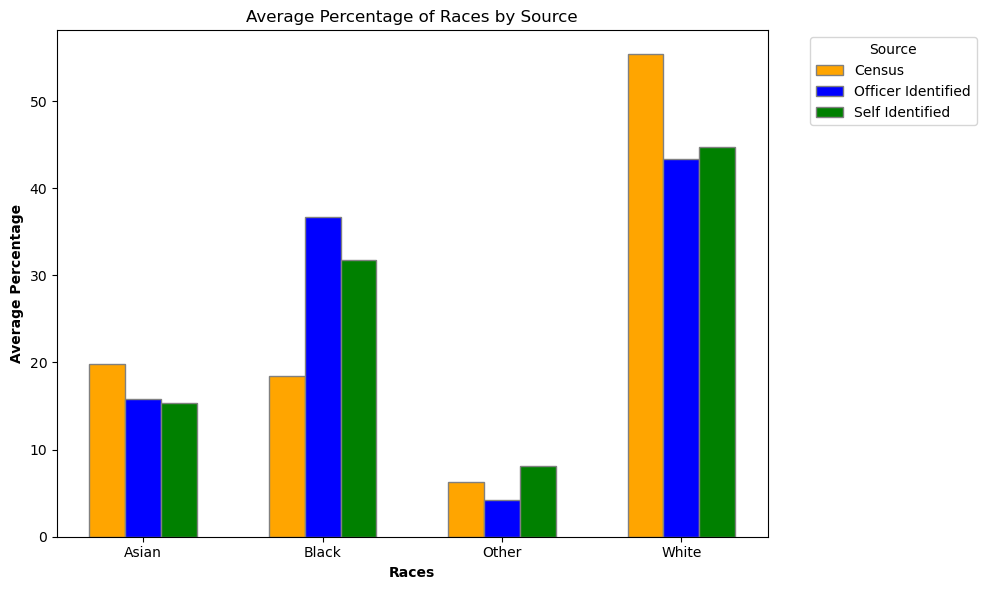

In [38]:
census_avg = df_census_percent[df_census_percent['Borough'] == 'Average'].drop('Borough', axis=1).values.flatten()
officer_avg = df_officer_identified_percent[df_officer_identified_percent['Borough'] == 'Average'].drop('Borough', axis=1).values.flatten()
self_avg = df_self_identified_percent[df_self_identified_percent['Borough'] == 'Average'].drop('Borough', axis=1).values.flatten()

# Define the positions and width for the bars
bar_width = 0.2
races = ['Asian', 'Black', 'Other', 'White']
r1 = np.arange(len(races))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Plotting the bars
plt.figure(figsize=(10, 6))

plt.bar(r1, census_avg, color='orange', width=bar_width, edgecolor='grey', label='Census')
plt.bar(r2, officer_avg, color='blue', width=bar_width, edgecolor='grey', label='Officer Identified')
plt.bar(r3, self_avg, color='green', width=bar_width, edgecolor='grey', label='Self Identified')

# Add labels
plt.xlabel('Races', fontweight='bold')
plt.ylabel('Average Percentage', fontweight='bold')
plt.title('Average Percentage of Races by Source')
plt.xticks([r + bar_width for r in range(len(races))], races)

# Add legend
plt.legend(title='Source', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [39]:
census_avg,officer_avg,self_avg

(array([19.86114758, 18.46794831,  6.32447578, 55.34642833]),
 array([15.81580639, 36.68934585,  4.18107882, 43.31376894]),
 array([15.39231801, 31.81005864,  8.08205644, 44.71556692]))

# Missidentified people map per borough (everyone and black)

In [40]:
# Calculate the mismatch count for each borough
df_missidentified = df_cop_person_borough[df_cop_person_borough['Self-defined ethnicity'] != df_cop_person_borough['Officer-defined ethnicity']]
df_missidentified_count = df_missidentified.groupby('Borough')['count'].sum().reset_index()

# Calculate the total count for each borough
df_total_count = df_cop_person_borough.groupby('Borough')['count'].sum().reset_index()

# Merge the mismatch count and total count dataframes
df_missidentified = df_missidentified_count.merge(df_total_count, on='Borough', suffixes=('_mismatch', '_total'))

# Calculate the percentage of mismatches
df_missidentified['percentage'] = (df_missidentified['count_mismatch'] / df_missidentified['count_total']) * 100

# Rename columns for clarity
df_missidentified = df_missidentified.rename(columns={'count_mismatch': 'mismatch_count', 'count_total': 'total_count'})

# Display the result
df_missidentified


Borough  mismatch_count  total_count  percentage
0     Barking and Dagenham            1783        27009    6.601503
1                   Barnet            2192        15034   14.580285
2                   Bexley             761        16350    4.654434
3                    Brent            4711        38811   12.138311
4                  Bromley            1887        31043    6.078665
5                   Camden            4154        39700   10.463476
6                  Croydon            4463        41062   10.868930
7                   Ealing            3268        35502    9.205115
8                  Enfield            3214        23832   13.486069
9                Greenwich            2877        37161    7.741988
10                 Hackney            3847        36284   10.602469
11  Hammersmith and Fulham            2723        20336   13.390047
12                Haringey            4591        37839   12.132984
13                  Harrow            1809        15926   11.358784
14                Havering            1241        20832    5.957181
15              Hillingdon            2045        27636    7.399768
16                Hounslow            2323        26893    8.637936
17               Islington            3549        31463   11.279916
18  Kensington and Chelsea            4311        28627   15.059210
19    Kingston upon Thames            1578        15116   10.439270
20                 Lambeth            5273        56414    9.346971
21                Lewisham            2708        32134    8.427211
22                  Merton            1284        13310    9.646882
23                  Newham            4080        61933    6.587764
24               Redbridge            1957        28460    6.876318
25    Richmond upon Thames             823         8833    9.317333
26               Southwark            5240        56300    9.307282
27                  Sutton             738        12275    6.012220
28           Tower Hamlets            3119        62969    4.953231
29          Waltham Forest            3324        39427    8.430771
30              Wandsworth            2403        21088   11.395106
31             Westminster           11345        67738   16.748354

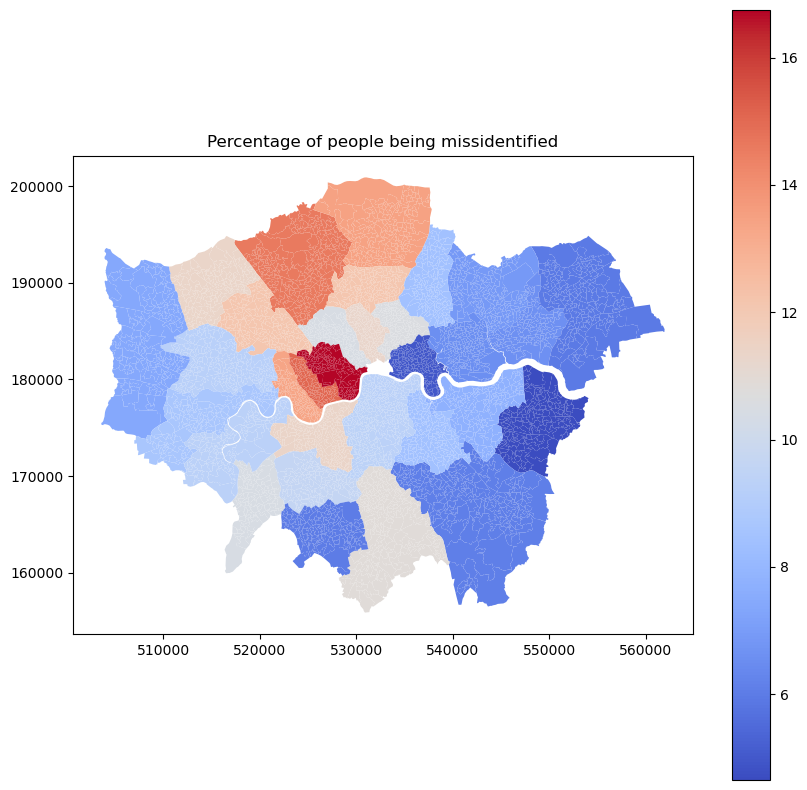

In [41]:
df_percentage_missidentified_map = df_missidentified[["Borough","percentage"]]
merged_gdf = shape.merge(df_percentage_missidentified_map, left_on='LAD11NM', right_on='Borough')

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
merged_gdf.plot(column='percentage', cmap='coolwarm', linewidth=0, ax=ax, edgecolor='1', legend=True)

plt.title('Percentage of people being missidentified')
plt.show()

In [42]:
# Calculate the mismatch count for each borough
df_black = df_cop_person_borough[df_cop_person_borough["Self-defined ethnicity"] == "Black"]
df_missidentified_black = df_black[df_black['Self-defined ethnicity'] != df_black['Officer-defined ethnicity']]
df_missidentified_count = df_missidentified_black.groupby('Borough')['count'].sum().reset_index()

# Calculate the total count for each borough
df_total_count = df_black.groupby('Borough')['count'].sum().reset_index()

# Merge the mismatch count and total count dataframes
df_missidentified_black = df_missidentified_count.merge(df_total_count, on='Borough', suffixes=('_mismatch', '_total'))

# Calculate the percentage of mismatches
df_missidentified_black['percentage'] = (df_missidentified_black['count_mismatch'] / df_missidentified_black['count_total']) * 100

# Rename columns for clarity
df_missidentified_black = df_missidentified_black.rename(columns={'count_mismatch': 'mismatch_count', 'count_total': 'total_count'})

# Display the result
df_missidentified_black


Borough  mismatch_count  total_count  percentage
0     Barking and Dagenham             127         7082    1.793279
1                   Barnet             124         4375    2.834286
2                   Bexley              53         2615    2.026769
3                    Brent             382        17992    2.123166
4                  Bromley             131         7140    1.834734
5                   Camden             359        12976    2.766646
6                  Croydon             210        16407    1.279941
7                   Ealing             277        12505    2.215114
8                  Enfield             129         8368    1.541587
9                Greenwich             176        12998    1.354054
10                 Hackney             292        17401    1.678064
11  Hammersmith and Fulham             252         7827    3.219624
12                Haringey             255        17192    1.483248
13                  Harrow             117         4884    2.395577
14                Havering              90         3858    2.332815
15              Hillingdon             180         7366    2.443660
16                Hounslow             152         5982    2.540956
17               Islington             358        11127    3.217399
18  Kensington and Chelsea             439         9554    4.594934
19    Kingston upon Thames              98         2406    4.073150
20                 Lambeth             334        34006    0.982180
21                Lewisham             178        16583    1.073388
22                  Merton              72         3371    2.135865
23                  Newham             335        19523    1.715925
24               Redbridge             159         6148    2.586207
25    Richmond upon Thames              44         1170    3.760684
26               Southwark             355        29075    1.220980
27                  Sutton              39         1939    2.011346
28           Tower Hamlets             282         9340    3.019272
29          Waltham Forest             300        12688    2.364439
30              Wandsworth             136         8570    1.586931
31             Westminster             902        19918    4.528567

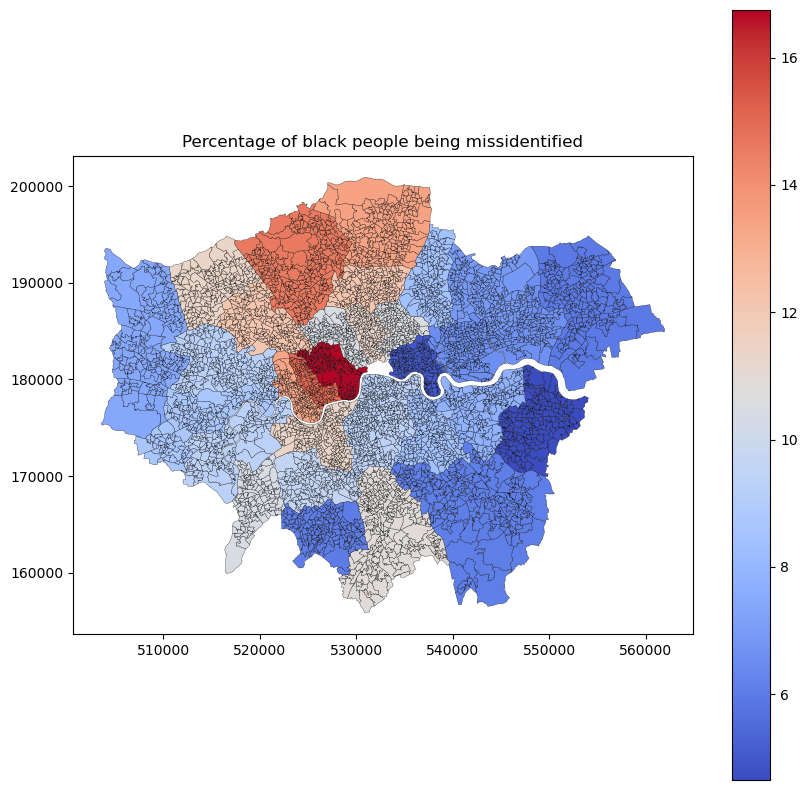

In [43]:
df_percentage_missidentified_black_map = df_missidentified_black[["Borough","percentage"]]
merged_gdf = shape.merge(df_percentage_missidentified_map, left_on='LAD11NM', right_on='Borough')

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
merged_gdf.plot(column='percentage', cmap='coolwarm', linewidth=0.2, ax=ax, edgecolor='black', legend=True)

plt.title('Percentage of black people being missidentified')
plt.show()

# SAS3 and SAS31 Mapping

In [78]:
df_pas_yes = df_pas_clean[df_pas_clean["SAS1"] == "Yes"]
df_pas_no = df_pas_clean[df_pas_clean["SAS1"] == "No"]

In [79]:
df_sas31 = df_pas_clean[df_pas_clean["SAS31"].isna() == False][["Borough","SAS31"]]
df_sas31_yes = df_pas_yes[df_pas_yes["SAS31"].isna() == False][["Borough","SAS31"]]
df_sas31_no = df_pas_no[df_pas_no["SAS31"].isna() == False][["Borough","SAS31"]]

In [80]:
def map_sas31(SAS31):
    if SAS31 == "Very confident":
        return 2
    elif SAS31 == "Fairly confident":
        return 1
    elif SAS31 == "Not very confident":
        return -1
    elif SAS31 == "Not at all confident":
        return -2
df_sas31["SAS31"] = df_sas31["SAS31"].apply(map_sas31)
df_sas31_yes["SAS31"] = df_sas31_yes["SAS31"].apply(map_sas31) 
df_sas31_no["SAS31"] = df_sas31_no["SAS31"].apply(map_sas31) 

In [81]:
df_sas31_grouped = df_sas31.groupby('Borough', as_index=False)['SAS31'].mean()
df_sas31_grouped = df_sas31_grouped.rename(columns={'SAS31': 'Average_SAS31'})

df_sas31_yes_grouped = df_sas31_yes.groupby('Borough', as_index=False)['SAS31'].mean()
df_sas31_yes_grouped = df_sas31_yes_grouped.rename(columns={'SAS31': 'Average_SAS31'})

df_sas31_no_grouped = df_sas31_no.groupby('Borough', as_index=False)['SAS31'].mean()
df_sas31_no_grouped = df_sas31_no_grouped.rename(columns={'SAS31': 'Average_SAS31'})

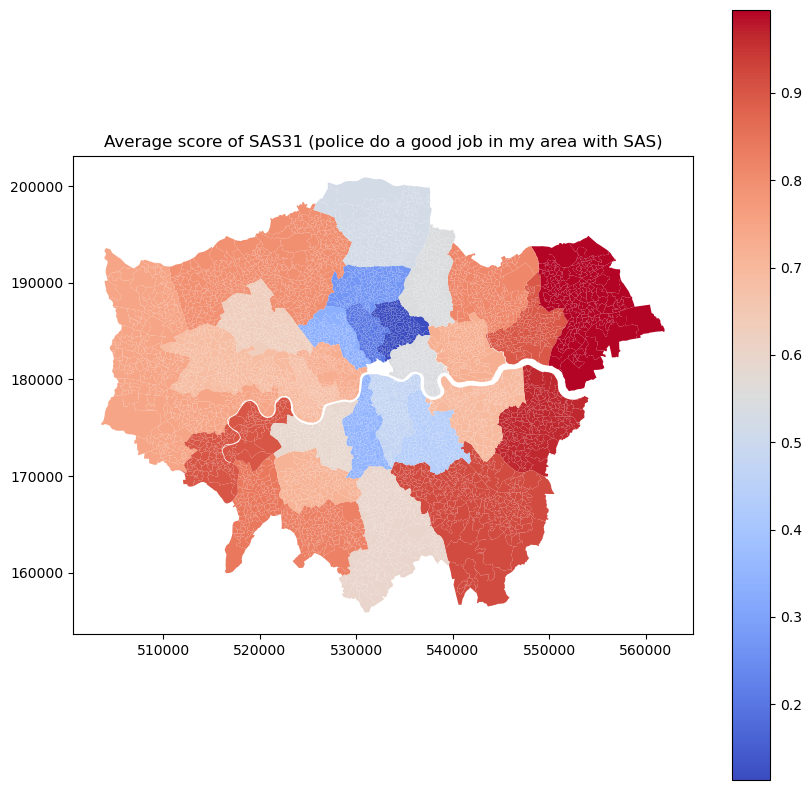

In [82]:
merged_gdf = shape.merge(df_sas31_grouped, left_on='LAD11NM', right_on='Borough')

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
merged_gdf.plot(column='Average_SAS31', cmap='coolwarm', linewidth=0, ax=ax, edgecolor='1', legend=True)

plt.title('Average score of SAS31 (police do a good job in my area with SAS)')
plt.show()

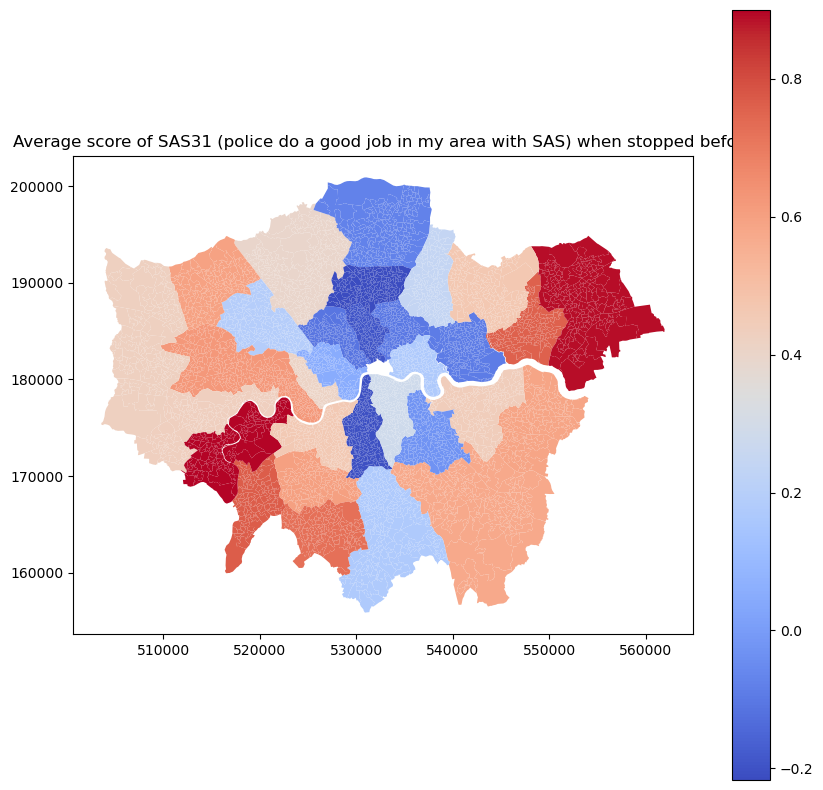

In [83]:
merged_gdf = shape.merge(df_sas31_yes_grouped, left_on='LAD11NM', right_on='Borough')

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
merged_gdf.plot(column='Average_SAS31', cmap='coolwarm', linewidth=0, ax=ax, edgecolor='1', legend=True)

plt.title('Average score of SAS31 (police do a good job in my area with SAS) when stopped before')
plt.show()

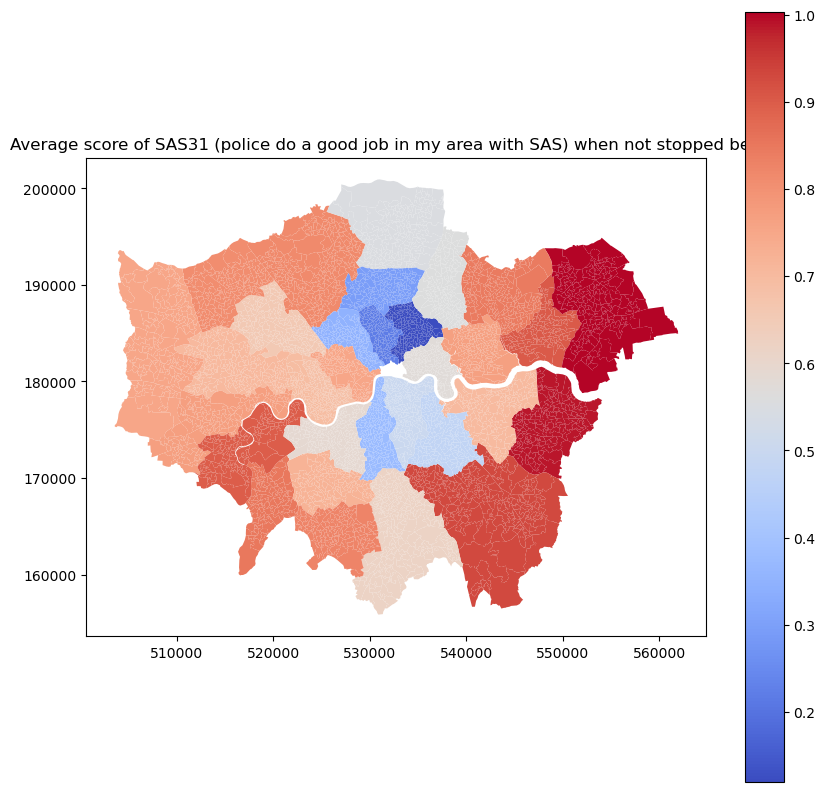

In [84]:
merged_gdf = shape.merge(df_sas31_no_grouped, left_on='LAD11NM', right_on='Borough')

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
merged_gdf.plot(column='Average_SAS31', cmap='coolwarm', linewidth=0, ax=ax, edgecolor='1', legend=True)

plt.title('Average score of SAS31 (police do a good job in my area with SAS) when not stopped before')
plt.show()

# Exploration of opinion on police change by race

In [85]:
df_pas_clean[["Ethnicity", "" "SAS14", "SAS15"]].dropna().count()

Ethnicity    2292
SAS14        2292
SAS15        2292
dtype: int64

In [86]:
df_pas_clean[df_pas_clean[["Ethnicity","SAS14","SAS15"]].isna() == False][["SAS14","SAS15"]].value_counts()

SAS14                     SAS15         
Generally high            Unchanged         1097
Mixed                     Unchanged          489
Generally high            Better opinion     173
Mixed                     Better opinion     110
Generally low             Unchanged          107
(spontaneous) No opinion  Unchanged           83
Mixed                     Worse opinion       74
Generally high            Worse opinion       57
Generally low             Worse opinion       56
                          Better opinion      39
(spontaneous) No opinion  Worse opinion       15
                          Better opinion      13
Name: count, dtype: int64

In [87]:
df_selected = df_pas_clean[['Borough',"Ethnicity", 'SAS14', 'SAS15']].copy()

# Map the SAS14 and SAS15 values
sas14_mapping = {'Generally low': -1, 'Mixed': 0, 'Generally high': 1}
sas15_mapping = {'Worse opinion': -1, 'Better opinion': 1, 'Unchanged': 0}

df_selected['SAS14'] = df_selected['SAS14'].map(sas14_mapping)
df_selected['SAS15'] = df_selected['SAS15'].map(sas15_mapping)

# Create the 'Change' column
df_selected['Change'] = df_selected['SAS14'] + df_selected['SAS15']

# Group by Borough and calculate the mean of SAS14, SAS15, and Change
df_opinion_change_grouped_ethnicity = df_selected.groupby(['Borough', "Ethnicity"]).mean().reset_index()

# Display the resulting DataFrame
df_opinion_change_grouped_ethnicity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Borough    144 non-null    object 
 1   Ethnicity  144 non-null    object 
 2   SAS14      128 non-null    float64
 3   SAS15      128 non-null    float64
 4   Change     128 non-null    float64
dtypes: float64(3), object(2)
memory usage: 5.8+ KB


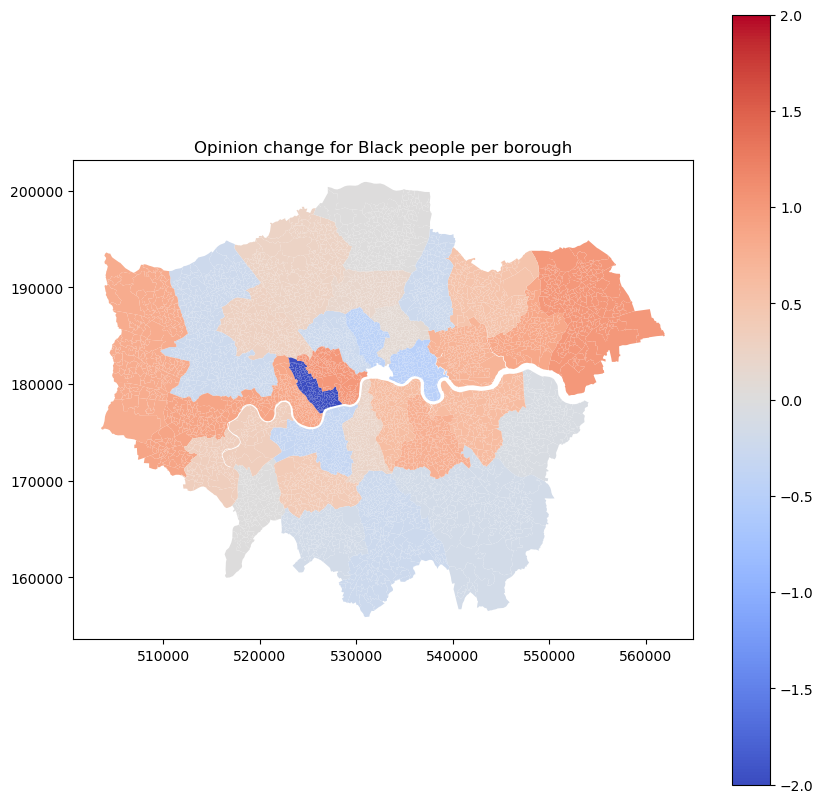

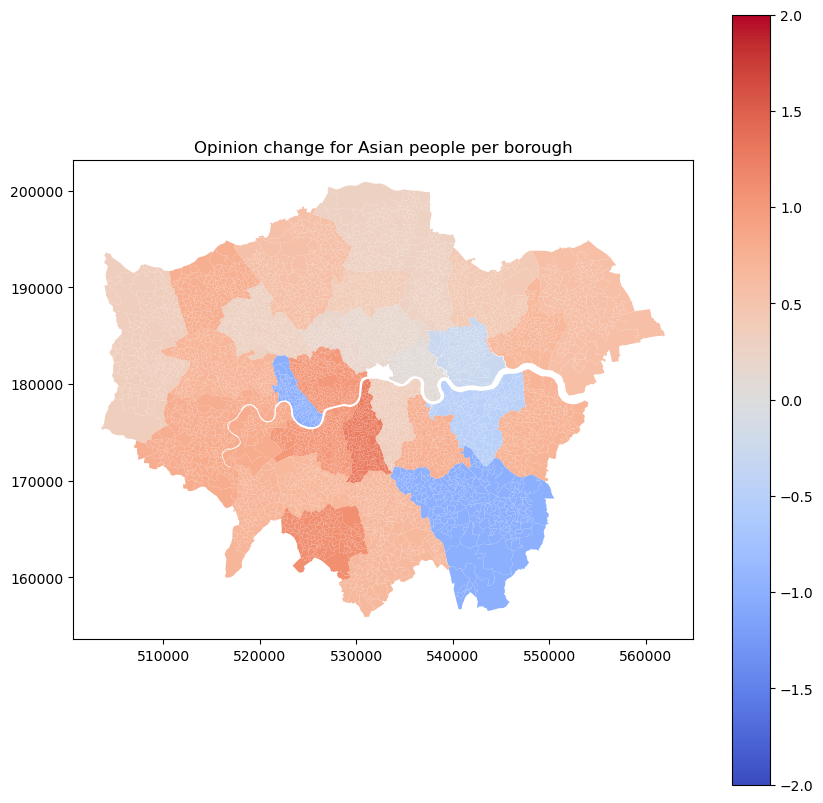

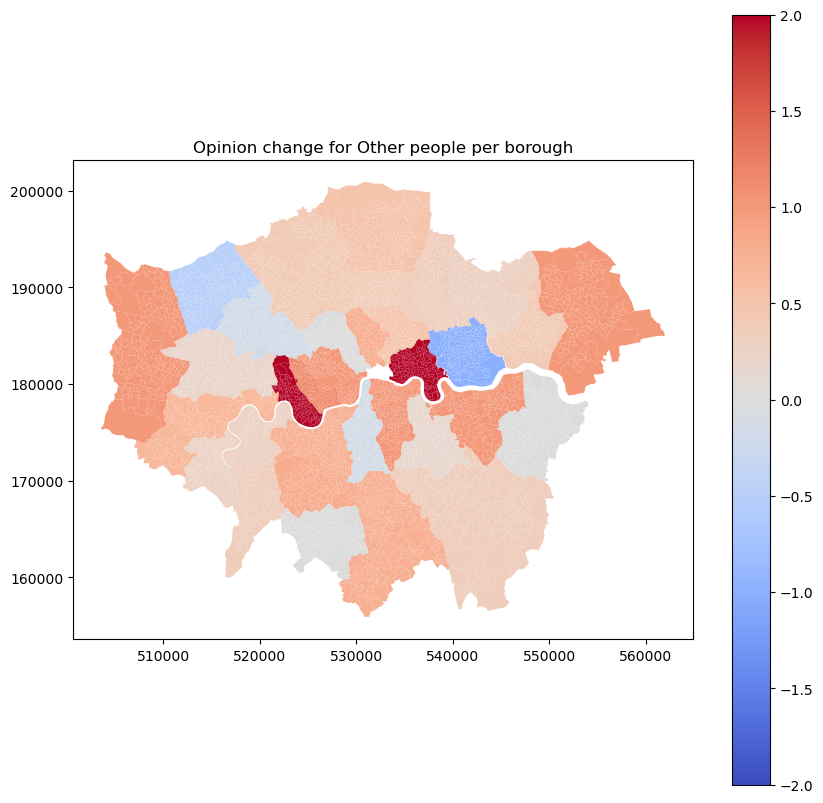

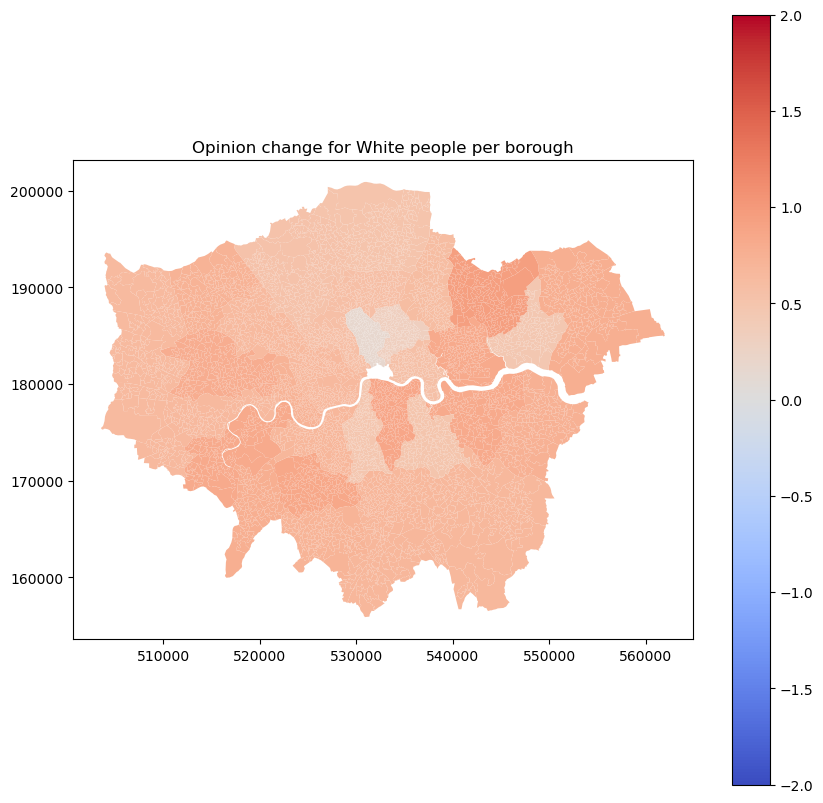

In [88]:
races = ["Black", "Asian", "Other", "White"]
for race in races:
    df_opinion_change_grouped_i = df_opinion_change_grouped_ethnicity[df_opinion_change_grouped_ethnicity["Ethnicity"] == race]
    merged_gdf = shape.merge(df_opinion_change_grouped_i, left_on='LAD11NM', right_on='Borough')
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    merged_gdf.plot(column='Change', cmap='coolwarm', linewidth=0, ax=ax, edgecolor='1', legend=True,vmin=-2, vmax=2)
    
    plt.title(f'Opinion change for {race} people per borough')
    plt.show()

# Change of opinion by age group

In [10]:
df_pas_clean[["Age","SAS14", "SAS15"]].dropna().count()

Age      2310
SAS14    2310
SAS15    2310
dtype: int64

In [16]:
df_pas_clean["Age"].value_counts()

Age
65 or over    13577
35-44         13327
25-34         12528
45-54          9953
55-64          7572
16-24          6501
35 to 44       2915
25 to 34       2748
65+            2599
55 to 64       1786
45 to 54       1669
16 to 24       1018
Refused           1
Name: count, dtype: int64

In [15]:
df_selected = df_pas_clean[df_pas_clean["FinancialYear"].isin(["2016/17","2017/18","2019/20","2018/19","2020/21"])]
df_selected = df_selected[['Age','Well informed']].copy()

# Map the SAS14 and SAS15 values
well_informed_mapping = {'Not at all informed': 1, 'Fairly well informed': 2, 'Very well informed': 3}

df_selected['Well informed'] = df_selected['Well informed'].map(well_informed_mapping)

# Group by Borough and calculate the mean of SAS14, SAS15, and Change
df_opinion_change_grouped_age = df_selected.groupby(["Age"]).mean().reset_index()

# Display the resulting DataFrame
df_opinion_change_grouped_age


Age  Well informed
0     16 to 24            NaN
1        16-24       1.438533
2     25 to 34            NaN
3        25-34       1.442833
4     35 to 44            NaN
5        35-44       1.505900
6     45 to 54            NaN
7        45-54       1.550957
8     55 to 64            NaN
9        55-64       1.528082
10  65 or over       1.550835
11         65+            NaN
12     Refused            NaN

In [13]:
df_selected = df_pas_clean[df_pas_clean["FinancialYear"].isin(["2016/17","2017/18","2019/20","2018/19","2020/21"])]
df_selected = df_selected[['Age','Borough','Well informed']].copy()

# Map the SAS14 and SAS15 values
well_informed_mapping = {'Not at all informed': 1, 'Fairly well informed': 2, 'Very well informed': 3}

df_selected['Well informed'] = df_selected['Well informed'].map(well_informed_mapping)

# Group by Borough and calculate the mean of SAS14, SAS15, and Change
df_opinion_change_grouped_age_borough = df_selected.groupby(['Borough',"Age"]).mean().reset_index()

# Display the resulting DataFrame
df_opinion_change_grouped_age_borough.dropna()


Borough         Age  Well informed
6    Barking and Dagenham       16-24       1.465116
7    Barking and Dagenham       25-34       1.515789
8    Barking and Dagenham       35-44       1.626667
9    Barking and Dagenham       45-54       1.616667
10   Barking and Dagenham       55-64       1.470588
..                    ...         ...            ...
376           Westminster       25-34       1.415730
378           Westminster       35-44       1.520408
380           Westminster       45-54       1.611940
382           Westminster       55-64       1.326087
383           Westminster  65 or over       1.517241

[192 rows x 3 columns]

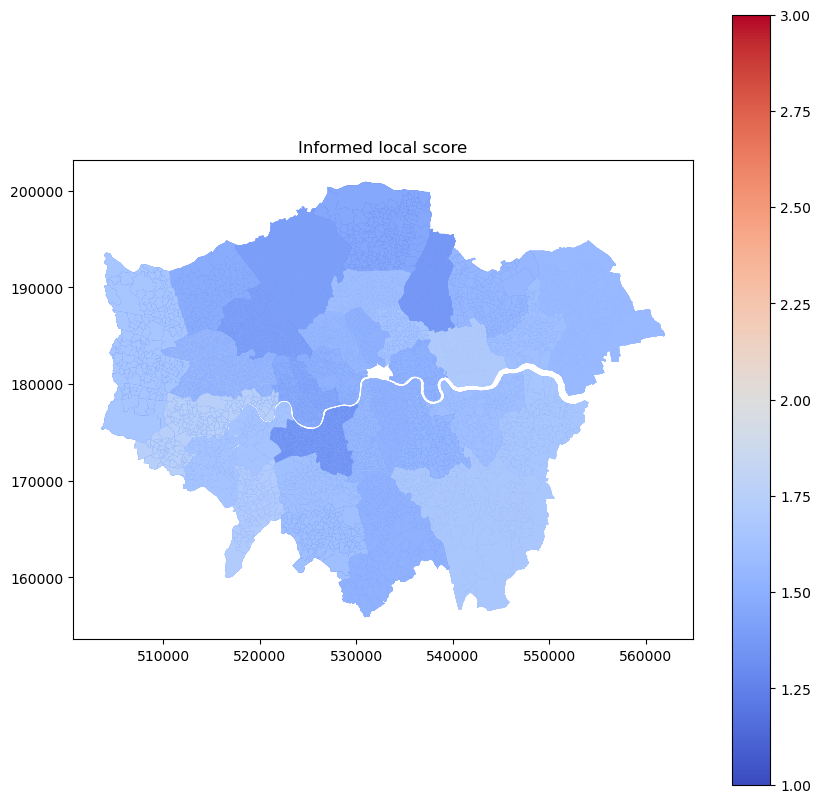

In [38]:
merged_gdf = shape.merge(df_opinion_change_grouped_age_borough, left_on='LAD11NM', right_on='Borough')
    
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
merged_gdf.plot(column='Well informed', cmap='coolwarm', linewidth=0, ax=ax, edgecolor='black', legend=True, vmin=1, vmax=3)
    
plt.title(f'Informed local score')
plt.savefig(f'average_informedscore_per_borough.png')
plt.show()

In [34]:
df_opinion_change_grouped

NameError: name 'df_opinion_change_grouped' is not defined

In [14]:
merged_gdf = shape.merge(df_opinion_change_grouped, left_on='LAD11NM', right_on='Borough')
    
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
merged_gdf.plot(column='Well informed', cmap='coolwarm', linewidth=0.05, ax=ax, edgecolor='black', legend=True, vmin=1, vmax=3)
    
plt.title(f'Informed local for {age} age group per borough')
plt.savefig(f'average_{age}_informedscore_per_borough.png')
plt.show()

NameError: name 'df_opinion_change_grouped' is not defined

# Change of opinion by employment status

In [93]:
df_pas_clean = pd.read_csv(pas_clean_path)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_16064\1681072638.py:1: DtypeWarning: Columns (7,8,11,12,13,14,15,16,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df_pas_clean = pd.read_csv(pas_clean_path)


In [94]:
df_pas_clean[["Employment","SAS14", "SAS15"]].dropna().count()

Employment    2305
SAS14         2305
SAS15         2305
dtype: int64

In [95]:
df_pas_clean['Employment'] = df_pas_clean['Employment'].replace(
    ['Unemployed', "Unemployed (registered and not registered)", "Don't know", "Not Working"], 
    'Not working'
)
df_pas_clean['Employment'] = df_pas_clean['Employment'].replace(
    "Full time (31+ hours per week)", 
    'Working FT'
)
df_pas_clean['Employment'] = df_pas_clean['Employment'].replace(
    "Part time (up to 30 hours per week)", 
    'Working PT'
)
df_pas_clean['Employment'] = df_pas_clean['Employment'].replace(
    ["Student/Education", "Student/full time education"], 
    'Student'
)
df_pas_clean['Employment'] = df_pas_clean['Employment'].replace(
    "House Person", 
    'House person'
)

In [96]:
df_pas_clean[df_pas_clean[["Employment","SAS14","SAS15"]].isna() == False][["Employment","SAS14","SAS15"]].value_counts()

Employment    SAS14                     SAS15         
Working FT    Generally high            Unchanged         531
              Mixed                     Unchanged         236
Retired       Generally high            Unchanged         228
Working PT    Generally high            Unchanged         169
Working FT    Generally high            Better opinion     84
                                                         ... 
Student       (spontaneous) No opinion  Better opinion      1
Not working   Generally low             Better opinion      1
Other         Mixed                     Better opinion      1
              (spontaneous) No opinion  Unchanged           1
House person  (spontaneous) No opinion  Unchanged           1
Name: count, Length: 77, dtype: int64

In [97]:
df_selected = df_pas_clean[['Employment',"Borough", 'SAS14', 'SAS15']].copy()

# Map the SAS14 and SAS15 values
sas14_mapping = {'Generally low': -1, 'Mixed': 0, 'Generally high': 1}
sas15_mapping = {'Worse opinion': -1, 'Better opinion': 1, 'Unchanged': 0}

df_selected['SAS14'] = df_selected['SAS14'].map(sas14_mapping)
df_selected['SAS15'] = df_selected['SAS15'].map(sas15_mapping)

# Create the 'Change' column
df_selected['Change'] = df_selected['SAS14'] + df_selected['SAS15']

# Group by Borough and calculate the mean of SAS14, SAS15, and Change
df_opinion_change_grouped_employment = df_selected.groupby(['Borough', "Employment"]).mean().reset_index()

# Display the resulting DataFrame
df_opinion_change_grouped_employment["Employment"].value_counts()

Employment
House person    36
Not working     36
Other           36
Retired         36
Student         36
Working FT      36
Working PT      36
Refused         32
Name: count, dtype: int64

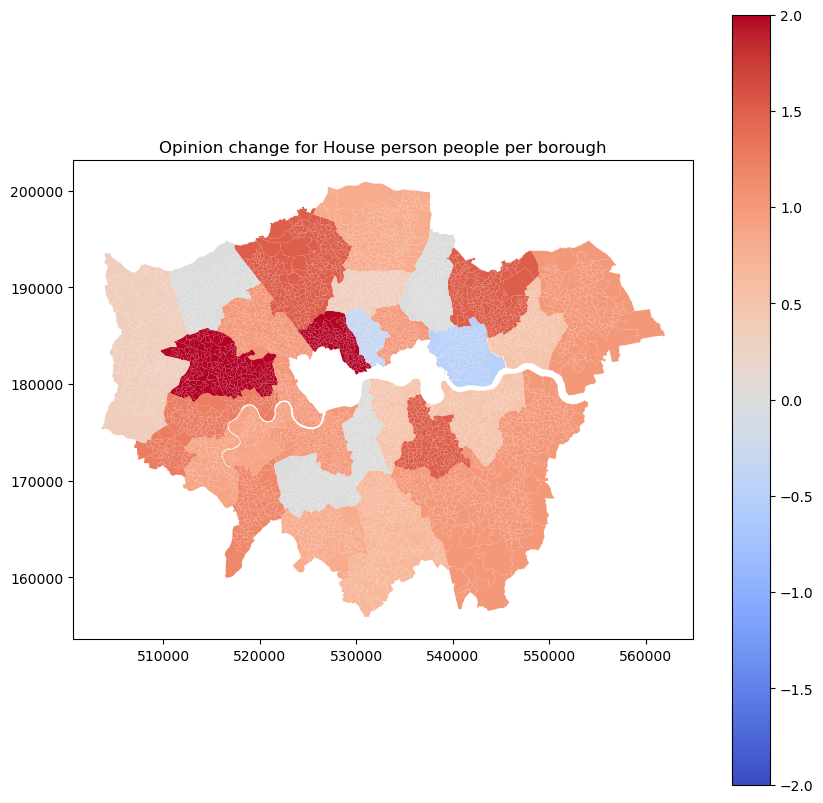

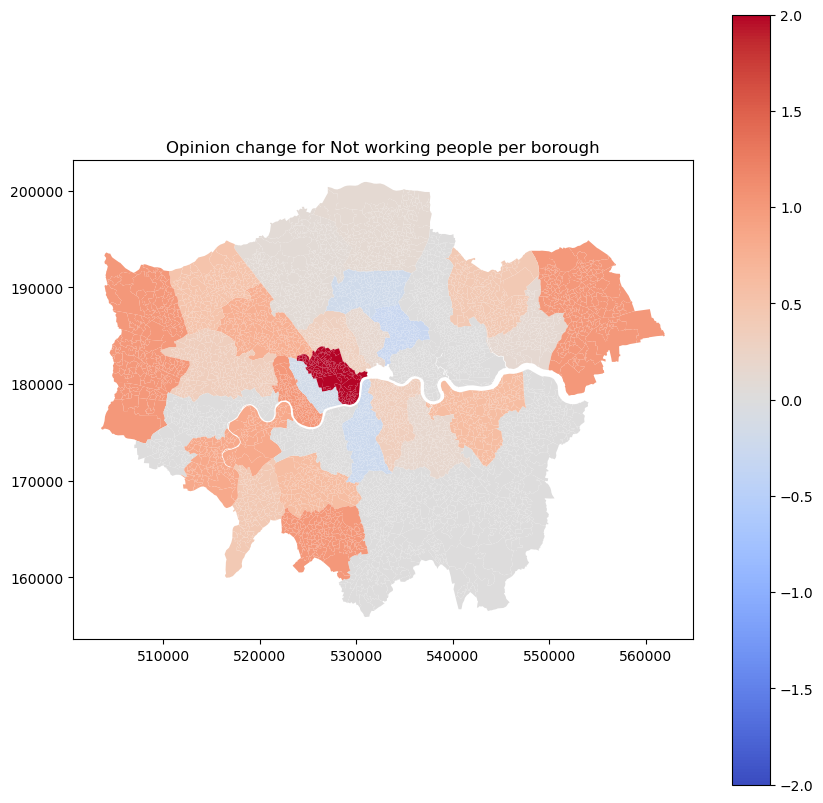

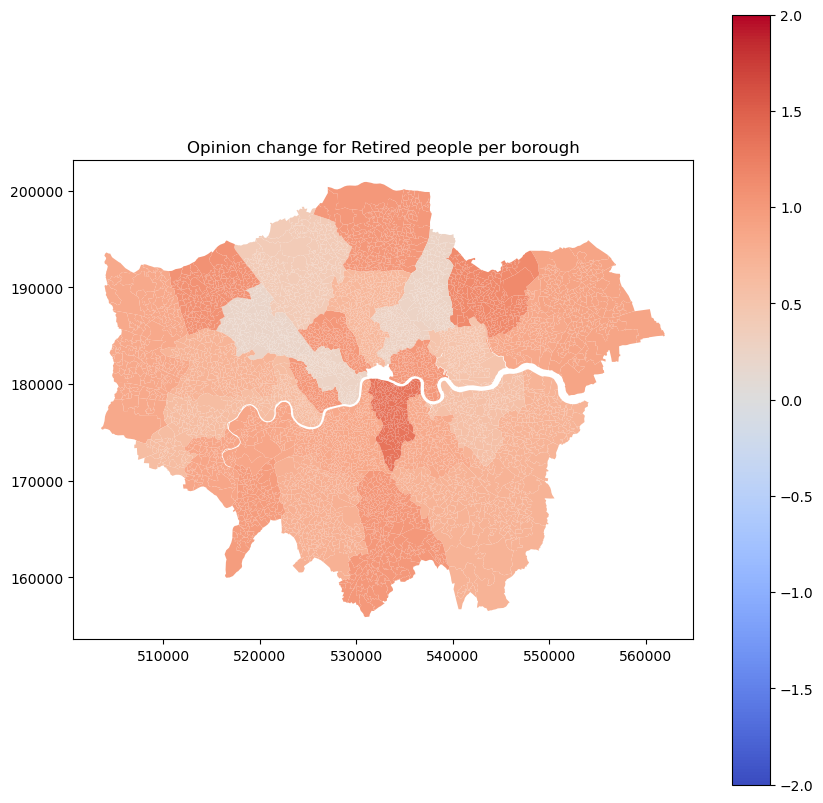

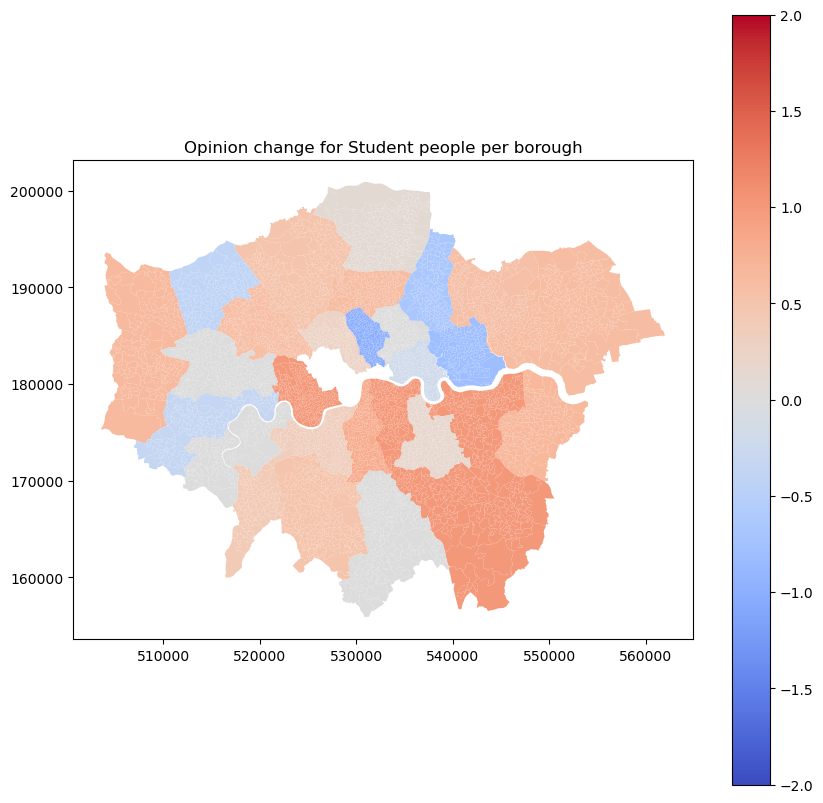

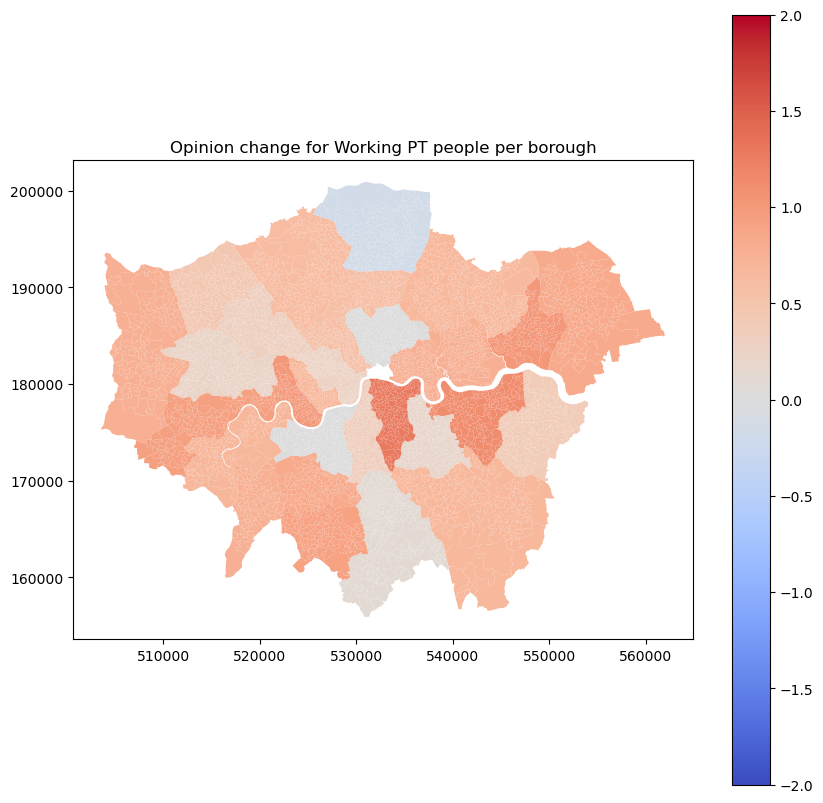

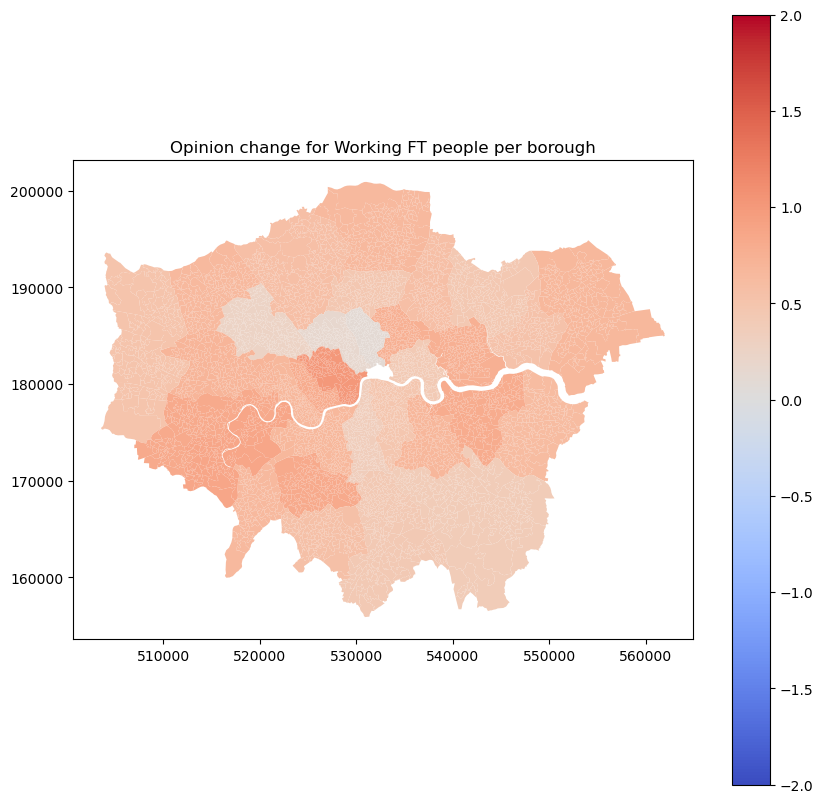

In [98]:
employments = ["House person","Not working", "Retired", "Student","Working PT","Working FT"]
for employment in employments:
    df_opinion_change_grouped_i = df_opinion_change_grouped_employment[df_opinion_change_grouped_employment["Employment"] == employment]
    merged_gdf = shape.merge(df_opinion_change_grouped_i, left_on='LAD11NM', right_on='Borough')
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    merged_gdf.plot(column='Change', cmap='coolwarm', linewidth=0, ax=ax, edgecolor='1', legend=True,vmin=-2, vmax=2)
    
    plt.title(f'Opinion change for {employment} people per borough')
    plt.show()

# TRUST AND CONFIDENCE MAPPING

In [8]:
df_pas_clean = pd.read_csv(pas_clean_path)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_16140\1681072638.py:1: DtypeWarning: Columns (7,8,11,12,13,14,15,16,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df_pas_clean = pd.read_csv(pas_clean_path)


In [9]:
df_trust_confidence['Date'] = pd.to_datetime(df_trust_confidence['Date'], format='%d/%m/%Y')

# Define a function to determine the financial year
def get_financial_year(date):
    if date.month < 4:
        return f"{date.year-1}/{date.year}"
    else:
        return f"{date.year}/{date.year+1}"

# Apply the function to create the FinancialYear column
df_trust_confidence['FinancialYear'] = df_trust_confidence['Date'].apply(get_financial_year)

# Filter the dataframe for the desired financial years
desired_years = ['2015/2016', '2016/2017', '2017/2018', '2018/2019', '2019/2020', '2020/2021']
df_trust_confidence_filtered = df_trust_confidence[df_trust_confidence['FinancialYear'].isin(desired_years)]
df_trust_confidence_filtered["Measure"].value_counts()
df_trust_confidence_filtered

def convert_financial_year_format(year):
    start_year = year.split('/')[0]
    end_year = year.split('/')[1][2:]  # Extracting the last two digits of the end year
    return f"{start_year}/{end_year}"

# Apply the conversion to the 'FinancialYear' column
df_trust_confidence_filtered['FinancialYear'] = df_trust_confidence_filtered['FinancialYear'].apply(convert_financial_year_format)
df_trust_confidence_filtered["Borough"].value_counts()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_16140\1644019661.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trust_confidence_filtered['FinancialYear'] = df_trust_confidence_filtered['FinancialYear'].apply(convert_financial_year_format)


Borough
Barking and Dagenham      189
Barnet                    189
Wandsworth                189
Waltham Forest            189
Tower Hamlets             189
Sutton                    189
Southwark                 189
Richmond upon Thames      189
Redbridge                 189
Newham                    189
Merton                    189
Lewisham                  189
Lambeth                   189
Kingston upon Thames      189
Kensington and Chelsea    189
Islington                 189
Hounslow                  189
Hillingdon                189
Havering                  189
Harrow                    189
Haringey                  189
Hammersmith and Fulham    189
Hackney                   189
Greenwich                 189
Enfield                   189
Ealing                    189
Croydon                   189
Camden                    189
Bromley                   189
Brent                     189
Bexley                    189
City of Westminster       189
Name: count, dtype: int64

In [10]:
df_pas_cols = ['Age', 'Employment', 'Ethnicity', 'FinancialYear', 'Borough',
       'SAS1', 'SAS14', 'SAS15', 'SAS3', 'SAS31', 'MPS Trust', 'Good Job',
       'Well informed', 'SAS11', 'SAS12', 'SAS13', 'SAS2', 'SAS21']
df_pas_x = ['Age', 'Employment', 'Ethnicity',
       'SAS1', 'SAS11','SAS12', 'SAS13', 'SAS14', 'SAS15', 'SAS2', 'SAS21', 'SAS3', 'SAS31']

In [11]:
df_pas_clean['Borough'] = df_pas_clean['Borough'].replace({
    'Hammersmith & Fulham': 'Hammersmith and Fulham',
    'Richmond Upon Thames': 'Richmond upon Thames',
    'Barking & Dagenham': 'Barking and Dagenham',
    'Kensington & Chelsea': 'Kensington and Chelsea',
})
df_trust_confidence_filtered["FinancialYear"].value_counts()

FinancialYear
2016/17    1024
2017/18    1024
2018/19    1024
2019/20    1024
2020/21    1024
2015/16     928
Name: count, dtype: int64

In [12]:
for i in df_pas_cols:
    print(df_pas_clean[i].value_counts())

Age
65 or over    13577
35-44         13327
25-34         12528
45-54          9953
55-64          7572
16-24          6501
35 to 44       2915
25 to 34       2748
65+            2599
55 to 64       1786
45 to 54       1669
16 to 24       1018
Refused           1
Name: count, dtype: int64
Employment
Working FT                                    27339
Retired                                       16397
Working PT                                     8227
Full time (31+ hours per week)                 5614
House Person                                   4185
Student/Education                              4028
Not Working                                    3627
Part time (up to 30 hours per week)            1829
Unemployed                                     1184
Other                                          1023
Not working                                     944
Unemployed (registered and not registered)      512
Student/full time education                     474
House person           

Consistency of ages, race and employment labels

In [13]:

# Assuming df_pas_clean is already defined and contains the Age column
df_pas_clean['Age'] = df_pas_clean['Age'].replace({
    '65 or over': '65+',
    '35 to 44': '35-44',
    '25 to 34': '25-34',
    '55 to 64': '55-64',
    '45 to 54': '45-54',
    '16 to 24': '16-24',
    '65+': '65+'
})
df_pas_clean['Employment'] = df_pas_clean['Employment'].replace({
    'Working FT': 'Full-time',
    'Working PT': 'Part-time',
    'Full time (31+ hours per week)': 'Full-time',
    'House Person': 'House person',
    'Student/Education': 'Student',
    'Not Working': 'Unemployed',
    'Part time (up to 30 hours per week)': 'Part-time',
    'Not working': 'Unemployed',
    'Unemployed (registered and not registered)': 'Unemployed',
    'Student/full time education': 'Student'
})
df_pas_clean['Ethnicity'] = df_pas_clean['Ethnicity'].replace({
    'White British': 'White',
    'White Other': 'White',
    'Mixed': 'Other'
})

In [14]:
df_pas_clean = df_pas_clean[df_pas_clean["Ethnicity"] != "Refused"]
df_pas_clean = df_pas_clean[df_pas_clean["Age"] != "Refused"]
df_pas_clean = df_pas_clean[df_pas_clean["Employment"].isin(["Refused", "Don't know", "Other"]) == False]


In [15]:
df_pas_clean = df_pas_clean[df_pas_clean["SAS14"] != "(spontaneous) No opinion"]
df_pas_clean = df_pas_clean[df_pas_clean["SAS21"] != "Not applicable - didn't hear anything"]

In [113]:
df_pivoted = df_trust_confidence_filtered.pivot_table(index=['FinancialYear', 'Borough'],
                                                 columns='Measure',
                                                 values='Proportion').reset_index()

# Flatten the columns
df_pivoted.columns = ['FinancialYear', 'Borough'] + [f"{measure}_proportion" for measure in df_pivoted.columns[2:]]

# Merge df_pas_clean with the pivoted df_trust_and_confidence
df_merged = pd.merge(df_pas_clean, df_pivoted, on=['FinancialYear', 'Borough'], how='left')
df_merged.info()

df_merged.to_csv("PAS SaS with ")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74611 entries, 0 to 74610
Data columns (total 27 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Unnamed: 0                        74611 non-null  int64  
 1   Age                               74408 non-null  object 
 2   Employment                        74214 non-null  object 
 3   Ethnicity                         73855 non-null  object 
 4   FinancialYear                     74611 non-null  object 
 5   Borough                           74611 non-null  object 
 6   SAS1                              71604 non-null  object 
 7   SAS14                             2174 non-null   object 
 8   SAS15                             2177 non-null   object 
 9   SAS3                              71120 non-null  object 
 10  SAS31                             64062 non-null  object 
 11  MPS Trust                         25284 non-null  object 
 12  Good

In [26]:
df_trust_confidence.columns

Index(['Date', 'Survey', 'Borough', 'Measure', 'Proportion', 'MPS',
       'FinancialYear'],
      dtype='object')

# Dashboard xlsx exploration

In [16]:
df_trust_confidence["Measure"].value_counts

<bound method IndexOpsMixin.value_counts of 0        "Good Job" local
1        "Good Job" local
2        "Good Job" local
3        "Good Job" local
4        "Good Job" local
              ...        
9307    Understand issues
9308    Understand issues
9309    Understand issues
9310    Understand issues
9311    Understand issues
Name: Measure, Length: 9312, dtype: object>

In [17]:
measures = ['"Good Job" local', 'Contact ward officer', 'Informed local', 'Listen to concerns', 'Relied on to be there', 'Treat everyone fairly', 'Understand issues']

In [18]:
df_trust_confidence['Proportion'] = df_trust_confidence['Proportion'].str.replace(',', '.').astype(float)
df_trust_confidence['MPS'] = df_trust_confidence['MPS'].str.replace(',', '.').astype(float)

In [22]:

df_trust_confidence = df_trust_confidence.drop(columns= ["Unnamed: 6","Unnamed: 7", "Unnamed: 8", "Unnamed: 9"])
df_trust_confidence = df_trust_confidence[df_trust_confidence["FinancialYear"].isin(["2016/2017","2017/2018","2018/2019","2019/2020","2020/2021"])]

In [23]:
df_grouped_trust_confidence = df_trust_confidence.groupby(['Borough', 'Measure']).agg({'Proportion': 'mean'}).reset_index()

# Rename columns for clarity if needed
df_grouped_trust_confidence.columns = ['Borough', 'Measure', 'Average_Proportion']

df_grouped_trust_confidence


Borough                Measure  Average_Proportion
0    Barking and Dagenham       "Good Job" local              0.6190
1    Barking and Dagenham   Contact ward officer              0.1860
2    Barking and Dagenham         Informed local              0.3845
3    Barking and Dagenham     Listen to concerns              0.7205
4    Barking and Dagenham  Relied on to be there              0.7300
..                    ...                    ...                 ...
251            Wandsworth     Listen to concerns              0.7575
252            Wandsworth  Relied on to be there              0.7595
253            Wandsworth  Treat everyone fairly              0.7820
254            Wandsworth              Trust MPS              0.8580
255            Wandsworth      Understand issues              0.7320

[256 rows x 3 columns]

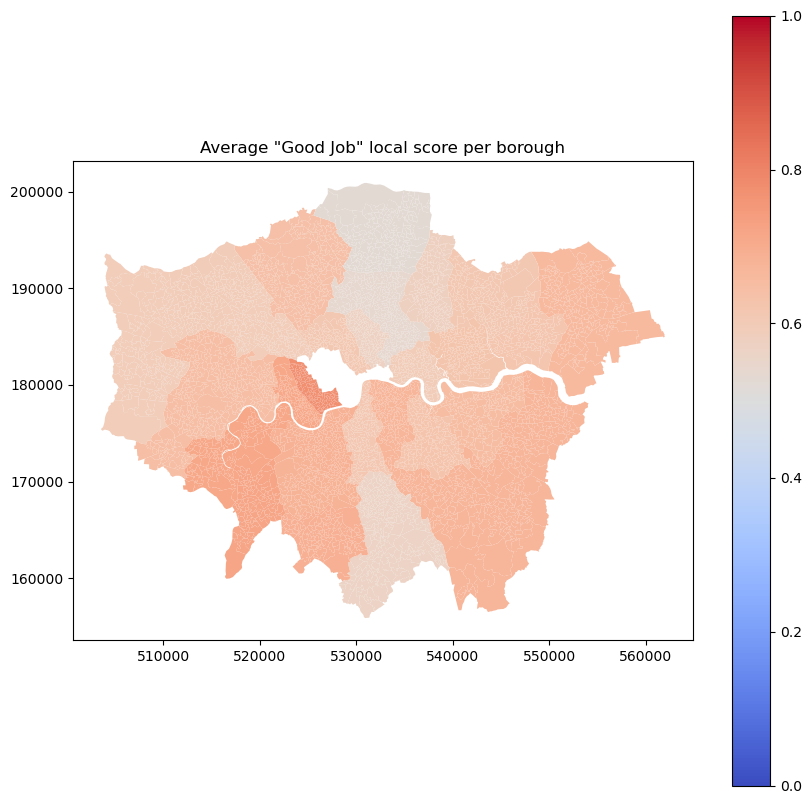

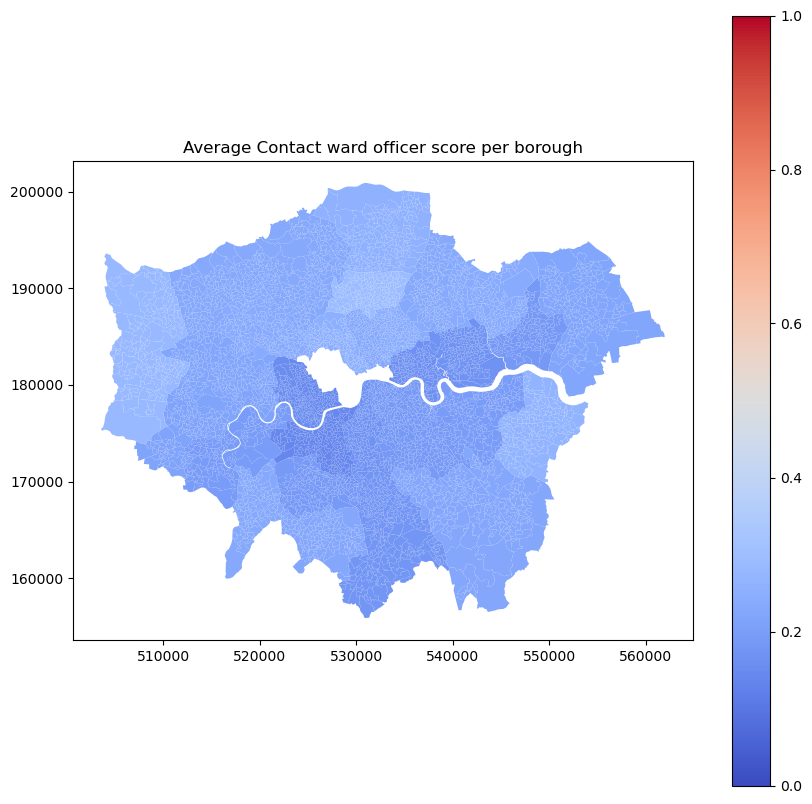

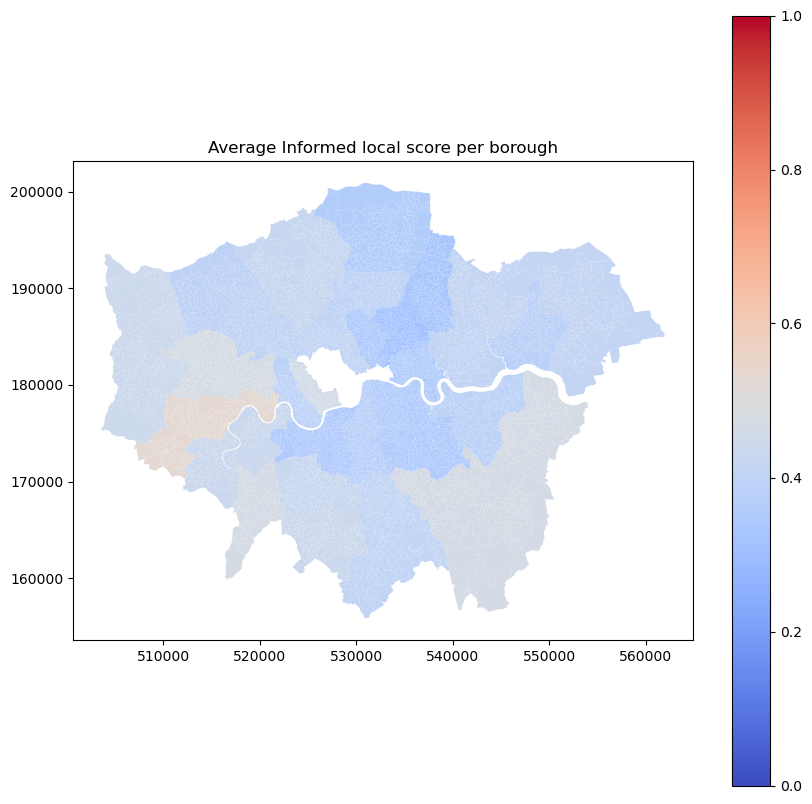

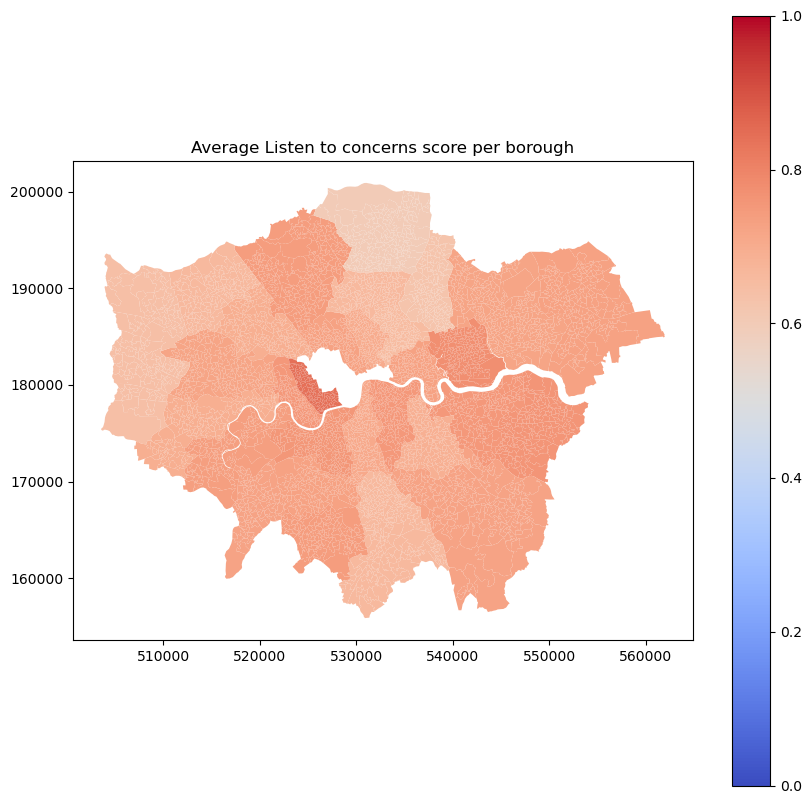

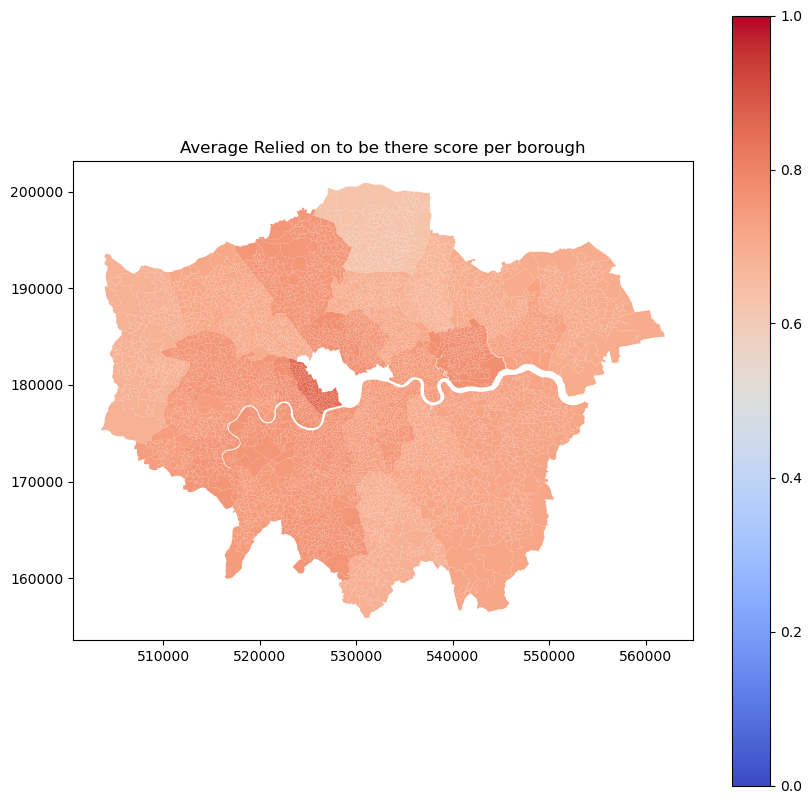

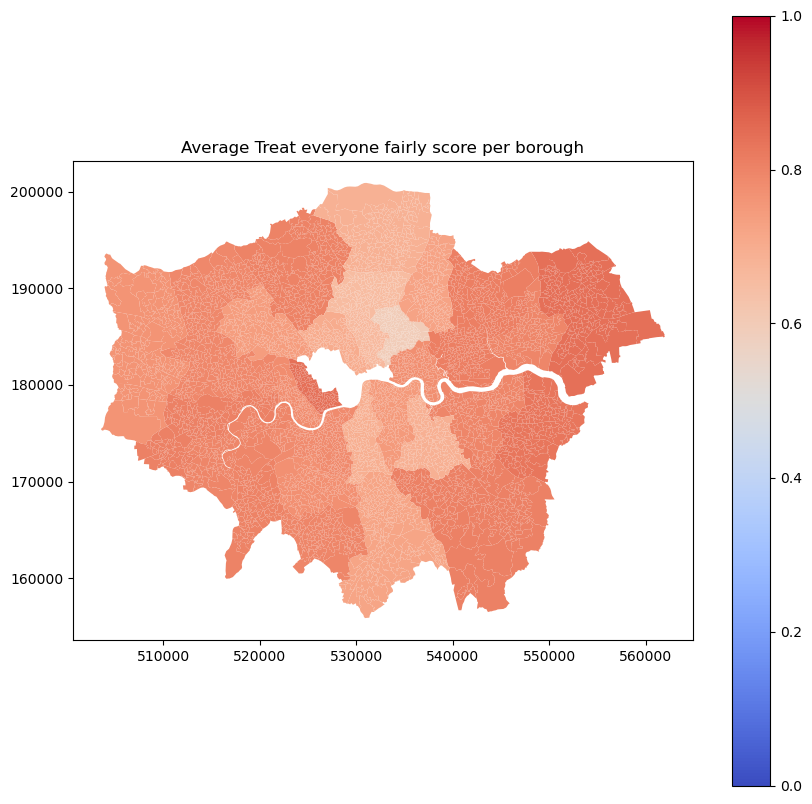

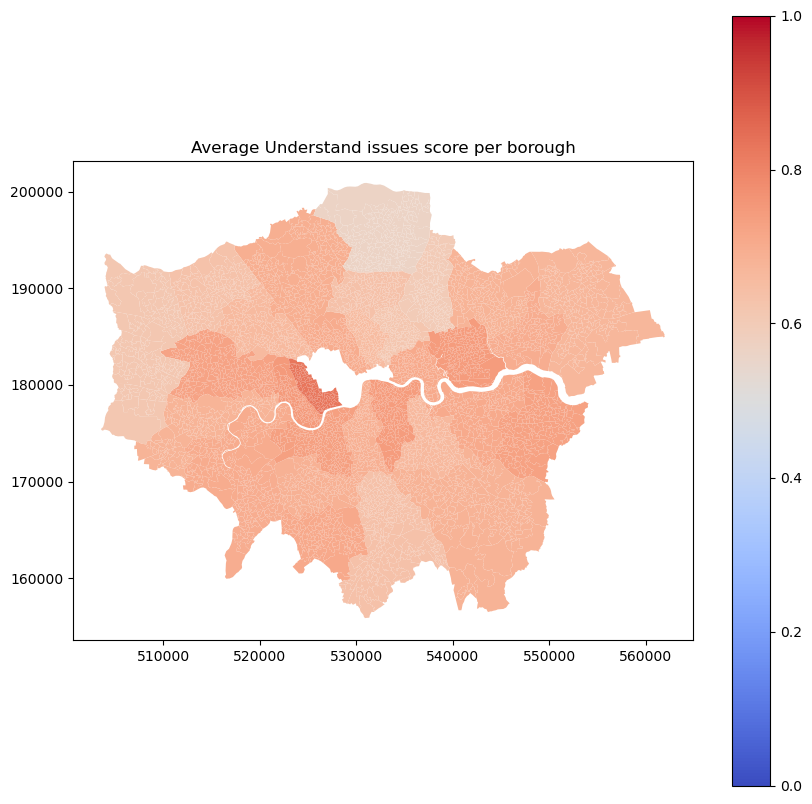

In [28]:

for measure in measures:
    # Clean the measure name to remove invalid characters for filenames
    clean_measure = "".join(c for c in measure if c.isalnum() or c in (" ", "_")).replace(" ", "_")
    
    df_grouped_trust_confidence_i = df_grouped_trust_confidence[df_grouped_trust_confidence["Measure"] == measure]
    merged_gdf = shape.merge(df_grouped_trust_confidence_i, left_on='LAD11NM', right_on='Borough')
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    merged_gdf.plot(column='Average_Proportion', cmap='coolwarm', linewidth=0, ax=ax, edgecolor='1', legend=True, vmin=0, vmax=1)
    
    plt.title(f'Average {measure} score per borough')
    plt.savefig(f'average_{clean_measure}_score_per_borough.png')
    plt.show()


In [ ]:
df_trust_confidence_filtered[["Measure", "Proportion", "Date"]]

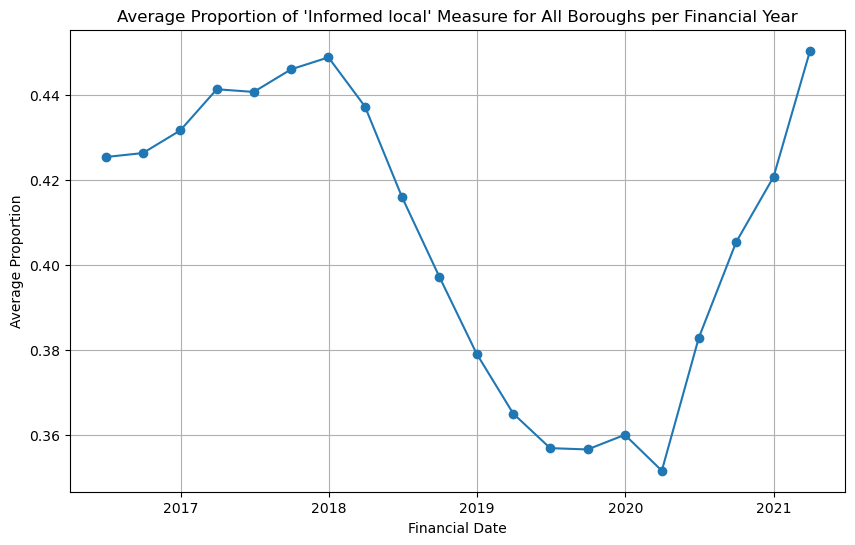

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter the dataframe for measure = "Informed local"
filtered_df = df_trust_confidence[df_trust_confidence["Measure"] == "Informed local"]

# Group by FinancialYear and calculate the average Proportion for each year
average_proportion_per_year = filtered_df.groupby("Date")["Proportion"].mean().reset_index()

# Plotting the average Proportion per FinancialYear
plt.figure(figsize=(10, 6))
plt.plot(average_proportion_per_year["Date"], average_proportion_per_year["Proportion"], marker='o')
plt.xlabel("Financial Date")
plt.ylabel("Average Proportion")
plt.title("Average Proportion of 'Informed local' Measure for All Boroughs per Financial Year")
plt.grid(True)
plt.show()
